In [1]:
import logging
import numpy as np
import pandas as pd
from arch import arch_model
from random import gauss
from random import seed
from matplotlib import pyplot as plt
import scipy.stats as sts
import json
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.optimize import least_squares
import os

In [2]:
ini_wd = os.getcwd()
# os.chdir('..')

In [3]:
from rules_related import combine_rules_outputs
from whole_algorithm import train_model
from auxiliary import calc_log_returns, unpack_1d_parameters, pack_1d_parameters
from multivariate_normal_distribution import LongMultivariateNormal
from model import FuzzyVolatilityModel
from membership_functions import calc_trapezoidal_membership_degrees
from clusterization.all_methods import cluster_data_1d, cluster_data
from local_models import calc_cond_var_fuzzy
from antecedent_fitting import fit_antecedent_params
# from membership_functions.trapezoidal import _calc_trapezoidal_md_scalar

In [4]:
with open('config.json') as file:
    config = json.load(file)

In [5]:
files_folder = config['files_folders']['processed']
logs_folder = config['files_folders']['logs']

In [6]:
logging.basicConfig(level=logging.DEBUG,
                    filename=f'{logs_folder}/seasonal_testing.log',
                    filemode='w',
                    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S')

In [7]:
pd.options.display.max_colwidth = 500

# Reading files

In [8]:
rtsi = pd.read_pickle(f'{files_folder}/rtsi.pkl')

In [9]:
rtsi

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,return,log return
<DATE>,,,,,,,
2001-02-18,180.10,180.10,180.10,180.10,0,0.000000,0.000000
2001-02-19,180.10,181.21,176.67,177.29,0,-0.015602,-0.015725
2001-02-20,177.29,179.90,175.28,176.45,0,-0.004738,-0.004749
2001-02-21,176.45,176.45,161.12,162.39,0,-0.079683,-0.083037
2001-02-22,162.39,168.35,162.39,168.31,0,0.036455,0.035807
...,...,...,...,...,...,...,...
2021-10-11,1871.73,1883.71,1867.58,1882.43,1769145502,0.011537,0.011471
2021-10-12,1867.15,1876.79,1860.64,1869.94,1386130631,-0.006635,-0.006657
2021-10-13,1869.05,1869.05,1835.80,1855.11,1830447018,-0.007931,-0.007962


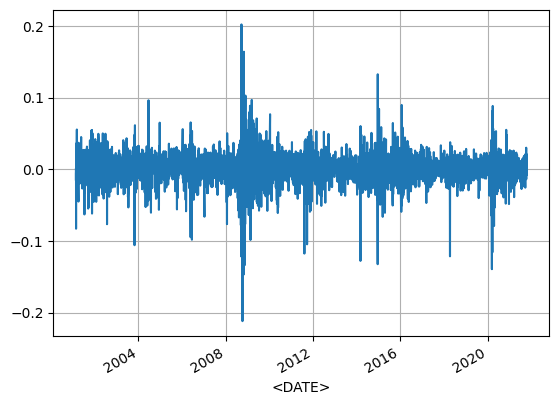

In [10]:
rtsi['log return'].plot()

plt.grid()
plt.show()

In [11]:
rtsi['log return'].describe()

count    5174.000000
mean        0.000455
std         0.020327
min        -0.211994
25%        -0.008822
50%         0.001318
75%         0.010414
max         0.202039
Name: log return, dtype: float64

In [12]:
rtsi['day of week'] = rtsi.index.dayofweek + 1

In [13]:
rtsi['day of week']

<DATE>
2001-02-18    7
2001-02-19    1
2001-02-20    2
2001-02-21    3
2001-02-22    4
             ..
2021-10-11    1
2021-10-12    2
2021-10-13    3
2021-10-14    4
2021-10-15    5
Name: day of week, Length: 5174, dtype: int64

In [14]:
# rtsi['test triangular cluster memb'] = \
calc_trapezoidal_membership_degrees(rtsi['day of week'].values,
                                    a=[0, 2],
                                    b=[2, 4],
                                    c=[2, 4],
                                    d=[4, 6])

array([0., 0.])

# Setting data & parameters

In [15]:
rescale_factor = 1

In [16]:
start_date = '2010-01-01'

In [17]:
input_data = rtsi['log return'].loc[start_date:].copy() * rescale_factor

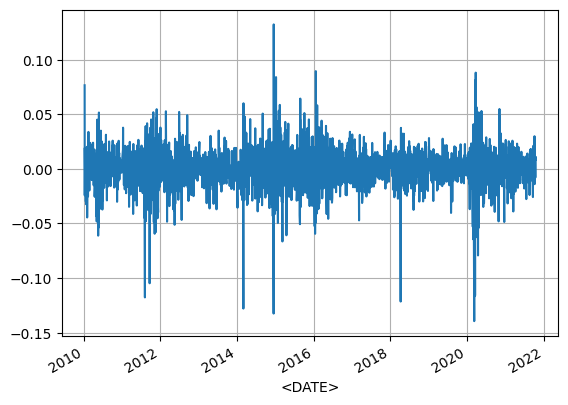

In [18]:
input_data.plot()

plt.grid()
plt.show()

In [19]:
input_data.describe()

count    2965.000000
mean        0.000091
std         0.017722
min        -0.139486
25%        -0.008678
50%         0.000601
75%         0.009209
max         0.132462
Name: log return, dtype: float64

In [20]:
n = input_data.shape[0]

In [21]:
n

2965

In [22]:
input_data.index.dayofweek + 1

Int64Index([1, 2, 3, 4, 5, 1, 2, 3, 4, 5,
            ...
            1, 2, 3, 4, 5, 1, 2, 3, 4, 5],
           dtype='int64', name='<DATE>', length=2965)

## Train / test split

In [23]:
n_train = 100  # 2000

n_test = 10
n_test = min(n - n_train, n_test)

In [24]:
train, test = input_data.iloc[:n_train].copy(), input_data.iloc[n_train:(n_train + n_test)].copy()
input_cut = pd.concat([train, test]).copy()
# data_to_cluster_train, data_to_cluster_test = days_of_week.iloc[:n_train].copy(), days_of_week.iloc[n_train:].copy()

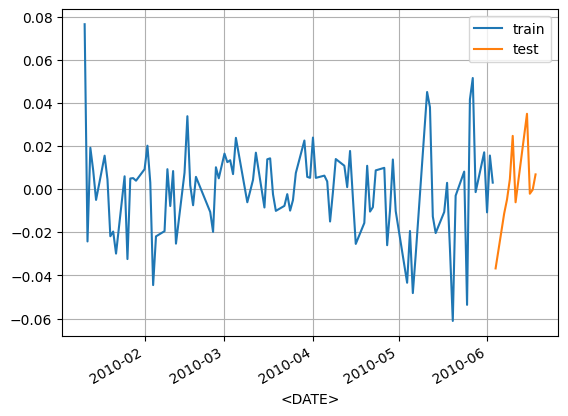

In [25]:
train.plot(label='train')
test.plot(label='test')

plt.legend()
plt.grid()
plt.show()

In [26]:
train.describe()

count    100.000000
mean      -0.000333
std        0.021419
min       -0.061136
25%       -0.010510
50%        0.003145
75%        0.010414
max        0.076686
Name: log return, dtype: float64

## Antecedent parameters

In [27]:
# set #1
clusterization_method_1 = 'trapezoidal'

n_clusters_1 = 2

a = [1, 1]
b = [1, 5]
c = [1, 5]
d = [5, 5]

# set #2
clusterization_method_2 = 'gaussian'

n_clusters_2 = 2

# variances = [7, 6, 3, 5]
# centers = [-7.5, -1.5, 1.5, 4]
variances = [7, 5]
centers = [-4.5, 2.5]

In [28]:
# rtsi['test triangular cluster memb'] = \
calc_trapezoidal_membership_degrees(2,
                                    a=a,
                                    b=b,
                                    c=c,
                                    d=d)

array([0.75, 0.25])

In [29]:
clusterization_parameters = [{'a': a, 'b': b, 'c': c, 'd': d, 'n_clusters': n_clusters_1},
                             {'centers': centers, 'variances': variances, 'n_clusters': n_clusters_2}]
clusterization_methods = [clusterization_method_1, clusterization_method_2]
n_clusters = n_clusters_1 * n_clusters_2

## Consequent parameters

In [30]:
# technical parameters for arch_model function
garch_mean = 'Zero'
garch_dist = 'normal'

# general parameters
local_method = 'garch'

# GARCH parameters
p = 1
q = 1

starting_index = max(p, q)

train_sample_std = train.std()
first_h = [train_sample_std ** 2] * starting_index
# first_h = [train[0] ** 2]  # TODO: TRY THIS
first_h = np.array(first_h)

# parameters constraints
lower_bounds = [0] * (1 + p + q) * n_clusters
upper_bounds = [+1000] * n_clusters + [1] * (p + q) * n_clusters
bounds = (lower_bounds, upper_bounds)

### Using classic GARCH to get initial parameters values

In [31]:
garch = arch_model(train,
                   mean=garch_mean,
                   vol='GARCH',
                   p=p,
                   q=q,
                   dist=garch_dist)
garch_fitted = garch.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: -172.81375246629065
Iteration:      2,   Func. Count:     14,   Neg. LLF: -231.83780274495433
Iteration:      3,   Func. Count:     21,   Neg. LLF: -246.87441129590061
Iteration:      4,   Func. Count:     28,   Neg. LLF: -246.6371189750122
Iteration:      5,   Func. Count:     33,   Neg. LLF: -250.4869892567008
Iteration:      6,   Func. Count:     37,   Neg. LLF: -250.4870954083915
Iteration:      7,   Func. Count:     41,   Neg. LLF: -250.4871000056945
Iteration:      8,   Func. Count:     44,   Neg. LLF: -250.4871000055288
Optimization terminated successfully    (Exit mode 0)
            Current function value: -250.4871000056945
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8


/Applications/anaconda3/envs/fuzzy-volatility/lib/python3.9/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004542. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [32]:
garch_fitted.params

omega       0.000018
alpha[1]    0.116398
beta[1]     0.836906
Name: params, dtype: float64

In [33]:
alpha_0_ini = np.array([garch_fitted.params.iloc[0] for _ in range(n_clusters)])
alpha_ini = np.array([garch_fitted.params.iloc[1:(q + 1)].values for _ in range(n_clusters)])
beta_ini = np.array([garch_fitted.params.iloc[(q + 1):].values for _ in range(n_clusters)])

In [34]:
# alpha_0_ini, alpha_ini, beta_ini = unpack_1d_parameters(garch_fitted.params.values, p=p, q=q, n_clusters=n_clusters)

In [35]:
parameters_ini = {'alpha_0': alpha_0_ini, 'alpha': alpha_ini, 'beta': beta_ini}

In [36]:
parameters_ini

{'alpha_0': array([1.76128451e-05, 1.76128451e-05, 1.76128451e-05, 1.76128451e-05]),
 'alpha': array([[0.11639833],
        [0.11639833],
        [0.11639833],
        [0.11639833]]),
 'beta': array([[0.8369058],
        [0.8369058],
        [0.8369058],
        [0.8369058]])}

In [37]:
# # initial parameters values for LS to start with
# alpha_0_ini = np.array([garch_fitted.params.loc['omega']] * n_clusters)
# alpha_ini = np.array([[1] * n_clusters] * q)
# beta_ini = np.array([[1] * n_clusters] * p)
# parameters_ini = {'alpha_0': alpha_0_ini, 'alpha': alpha_ini, 'beta': beta_ini}

In [38]:
list(alpha_ini.flatten())

[0.11639832899030729,
 0.11639832899030729,
 0.11639832899030729,
 0.11639832899030729]

### Setting dict w/ all consequent parameters

In [39]:
local_method_parameters = {'p': p, 'q': q, 'mean': garch_mean, 'dist': garch_dist, 'first_h': first_h,
                           'bounds': bounds, 'parameters_ini': parameters_ini}

## Other params

In [40]:
n_last_points_to_use_for_clustering_1 = 1
n_last_points_to_use_for_clustering_2 = 5
n_last_points_to_use_for_clustering = [n_last_points_to_use_for_clustering_1, n_last_points_to_use_for_clustering_2]

In [41]:
data_to_cluster_1 = pd.Series(train.index.dayofweek + 1, index=train.index).copy()
data_to_cluster_2 = 'train'
data_to_cluster = [data_to_cluster_1, data_to_cluster_2]

In [42]:
cluster_sets_conjunction = 'prod'

normalize = True

n_points_fitting = 10

optimization = 'ls'
optimization_parameters = {'ftol': 1e-10,
                           'gtol': 1e-10,
                           'method': 'dogbox'}

# Testing `FuzzyVolatilityModel` class

In [43]:
fvm = FuzzyVolatilityModel(train,
                           clusterization_method=clusterization_methods,
                           clusterization_parameters=clusterization_parameters,
                           local_method=local_method,
                           local_method_parameters=local_method_parameters,
                           n_last_points_to_use_for_clustering=n_last_points_to_use_for_clustering,
                           data_to_cluster=data_to_cluster,
                           cluster_sets_conjunction=cluster_sets_conjunction,
                           normalize=normalize,
                           n_points_fitting=n_points_fitting,
                           optimization=optimization,
                           optimization_parameters=optimization_parameters)

## `fit`

In [44]:
%%time

fvm.cluster()

CPU times: user 11.1 ms, sys: 2.92 ms, total: 14 ms
Wall time: 14.4 ms


In [45]:
fvm._fitting_slice

slice(-10, None, None)

In [46]:
%%time

fvm.fit()

KeyboardInterrupt: 

In [47]:
fvm.bounds

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1000, 1000, 1000, 1000, 1, 1, 1, 1, 1, 1, 1, 1])

In [48]:
np.array(fvm.bounds).T

array([[   0, 1000],
       [   0, 1000],
       [   0, 1000],
       [   0, 1000],
       [   0,    1],
       [   0,    1],
       [   0,    1],
       [   0,    1],
       [   0,    1],
       [   0,    1],
       [   0,    1],
       [   0,    1]])

In [49]:
fvm._fitting_slice

slice(None, None, None)

In [50]:
n_last_points_to_use_for_clustering

[1, 5]

In [51]:
fvm.alpha_0

In [52]:
fvm.alpha

In [53]:
fvm.beta

In [54]:
garch_fitted.params

omega       0.000018
alpha[1]    0.116398
beta[1]     0.836906
Name: params, dtype: float64

In [55]:
fvm._parameters_hist

[]

In [56]:
fvm.membership_degrees_current

array([0.00171404, 0.24828596, 0.00514212, 0.74485788], dtype=float128)

In [57]:
fvm.clusters_parameters_current

{'n_clusters': 4,
 'params by sets': [{'a': [1, 1],
   'b': [1, 5],
   'c': [1, 5],
   'd': [5, 5],
   'n_clusters': 2},
  {'centers': [-4.5, 2.5], 'variances': [7, 5], 'n_clusters': 2}]}

In [58]:
data_to_cluster

[<DATE>
 2010-01-11    1
 2010-01-12    2
 2010-01-13    3
 2010-01-14    4
 2010-01-15    5
              ..
 2010-05-28    5
 2010-05-31    1
 2010-06-01    2
 2010-06-02    3
 2010-06-03    4
 Name: <DATE>, Length: 100, dtype: int64,
 'train']

In [59]:
fvm._membership_degrees_hist

[array([0.00171404, 0.24828596, 0.00514212, 0.74485788], dtype=float128)]

In [60]:
fvm.train_data

<DATE>
2010-01-11    0.076686
2010-01-12   -0.024211
2010-01-13    0.019327
2010-01-14    0.008749
2010-01-15   -0.004911
                ...   
2010-05-28   -0.001298
2010-05-31    0.017188
2010-06-01   -0.010699
2010-06-02    0.015701
2010-06-03    0.003104
Name: log return, Length: 100, dtype: float64

## `forecast`

In [61]:
fvm.forecast()

TypeError: object of type 'NoneType' has no len()

In [ ]:
fvm.current_output

In [ ]:
fvm._hist_output

In [ ]:
plt.plot(fvm.h, label='$h_t$')
plt.plot(train.values ** 2, label='$y_t^2$')

plt.legend()
plt.grid()
plt.show()

## `feed_daily_data`

In [ ]:
n_test_small = 10
test_small = test.iloc[:n_test_small].copy()
input_cut = pd.concat([train, test_small]).copy()

data_to_cluster_test_1 = pd.Series(test_small.index.dayofweek + 1, index=test_small.index).copy()
data_to_cluster_test_2 = 'train'
data_to_cluster_test = [data_to_cluster_test_1, data_to_cluster_test_2]
# data_to_cluster = test_small.index.dayofweek + 1
# data_to_cluster = pd.Series(data_to_cluster, index=test_small.index)

In [ ]:
data_to_cluster_test

In [ ]:
fvm._membership_degrees_hist

In [ ]:
%%time

fvm.feed_daily_data(test_small, data_to_cluster=data_to_cluster_test)

In [ ]:
fvm.data_to_cluster

In [ ]:
fvm.h

In [ ]:
fvm.membership_degrees_hist

In [ ]:
pd.DataFrame.from_records(fvm._parameters_hist, index=fvm.train_data.index[-len(fvm._parameters_hist):])

In [ ]:
ls_res = fvm.show_ls_results()
ls_res

In [ ]:
fvm.hist_output

In [ ]:
fvm._parameters_hist

## Plots

In [ ]:
fvm.hist_output.plot(label='forecast')
(test_small ** 2).plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

In [ ]:
fvm.hist_output.plot(label='forecast')
(input_cut ** 2).plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

In [ ]:
_h_w_nans = np.concatenate([[np.nan for _ in range(input_cut.shape[0] - n_points_fitting)], fvm.h])

plt.plot(_h_w_nans, label='$h_t$')
plt.plot(input_cut.values ** 2, label='$y_t^2$')

plt.legend()
plt.grid()
plt.show()

In [ ]:
input_cut[-n_points_fitting:] ** 2

In [ ]:
fvm._h_hist

In [ ]:
fvm._hist_output

In [ ]:
_p = fvm._parameters_hist[-1]
_p

In [ ]:
calc_cond_var_fuzzy(_p['alpha_0'], _p['alpha'], _p['beta'],
                    input_cut[-n_points_fitting:] ** 2, [input_cut[-n_points_fitting:][0]],
                    fvm._membership_degrees_hist[-1])

In [ ]:
fvm._membership_degrees_hist[-1]

## Errors

In [ ]:
mean_squared_error(fvm.hist_output, test_small ** 2, squared=True)

In [ ]:
mean_squared_error(fvm.hist_output, test_small ** 2, squared=False)

In [ ]:
mean_absolute_percentage_error(fvm.hist_output, test_small ** 2)

## RSS plots

In [ ]:
ranges = {}

_step = .05
ranges['alpha_0'] = np.arange(0, 1 + _step, _step)

_step = .05
ranges['alpha'] = np.arange(0, 1 + _step, _step)

_step = .05
ranges['beta'] = np.arange(0, 1 + _step, _step)

In [ ]:
%%time

rss = {'alpha_0': [], 'alpha': [], 'beta': []}

for _param_1cl in ranges['alpha_0']:
    _alpha_0 = np.concatenate([fvm.alpha_0[:-1], [_param_1cl]])
    _params = pack_1d_parameters(_alpha_0, fvm.alpha, fvm.beta)
    rss['alpha_0'].append((fvm._calc_residuals(_params) ** 2).sum())
    
for _param_1cl in ranges['alpha']:
    _alpha = np.concatenate([fvm.alpha[:, :-1], [[_param_1cl]]], axis=1)
    _params = pack_1d_parameters(fvm.alpha_0, _alpha, fvm.beta)
    rss['alpha'].append((fvm._calc_residuals(_params) ** 2).sum())
    
for _param_1cl in ranges['beta']:
    _beta = np.concatenate([fvm.beta[:, :-1], [[_param_1cl]]], axis=1)
    _params = pack_1d_parameters(fvm.alpha_0, fvm.alpha, _beta)
    rss['beta'].append((fvm._calc_residuals(_params) ** 2).sum())

In [ ]:
%%time

rss = {'alpha_0': {i: [] for i in range(n_clusters)},
       'alpha': {i: [] for i in range(n_clusters)},
       'beta': {i: [] for i in range(n_clusters)}}

for i in range(n_clusters):
    for _param_1cl in ranges['alpha_0']:
        _alpha_0 = np.concatenate([fvm.alpha_0[:i], [_param_1cl], fvm.alpha_0[i + 1:]])
        
        _params = pack_1d_parameters(_alpha_0, fvm.alpha, fvm.beta)
        rss['alpha_0'][i].append((fvm._calc_residuals(_params) ** 2).sum())

_par_name = 'alpha'
for i in range(n_clusters):
    for _param_1cl in ranges[_par_name]:
        _alpha = fvm.alpha.copy()
        _alpha[0, i] = _param_1cl
        
        _params = pack_1d_parameters(fvm.alpha_0, _alpha, fvm.beta)
        rss[_par_name][i].append((fvm._calc_residuals(_params) ** 2).sum())
       
_par_name = 'beta'
for i in range(n_clusters):
    for _param_1cl in ranges[_par_name]:
        _beta = fvm.alpha.copy()
        _beta[0, i] = _param_1cl
        
        _params = pack_1d_parameters(fvm.alpha_0, fvm.alpha, _beta)
        rss[_par_name][i].append((fvm._calc_residuals(_params) ** 2).sum())

In [ ]:
for _param, _rss_cl in rss.items():
    for _cl, _rss in _rss_cl.items():
        plt.plot(ranges[_param], _rss)

        plt.grid()
        plt.title(_param + '\n' + f'cluster #{_cl}')
        plt.show()

# Model w/o seasoning

In [ ]:
lower_bounds_2 = [0] * (1 + p + q) * n_clusters_2
upper_bounds_2 = [+np.inf] * n_clusters_2 + [1] * (p + q) * n_clusters_2
bounds_2 = (lower_bounds_2, upper_bounds_2)

In [ ]:
alpha_0_ini_2 = np.array([garch_fitted.params.iloc[0] for _ in range(n_clusters_2)])
alpha_ini_2 = np.array([garch_fitted.params.iloc[1:(q + 1)].values for _ in range(n_clusters_2)])
beta_ini_2 = np.array([garch_fitted.params.iloc[(q + 1):].values for _ in range(n_clusters_2)])

In [ ]:
parameters_ini_2 = {'alpha_0': alpha_0_ini_2, 'alpha': alpha_ini_2, 'beta': beta_ini_2}

In [ ]:
local_method_parameters_2 = local_method_parameters.copy()
local_method_parameters_2['bounds'] = bounds_2
local_method_parameters_2['parameters_ini'] = parameters_ini_2

In [ ]:
fvm_vanilla = FuzzyVolatilityModel(train,
                           clusterization_method=clusterization_methods[1],
                           clusterization_parameters=clusterization_parameters[1],
                           local_method=local_method,
                           local_method_parameters=local_method_parameters_2,
                           n_last_points_to_use_for_clustering=n_last_points_to_use_for_clustering[1],
                           data_to_cluster=data_to_cluster[1],
                           cluster_sets_conjunction=cluster_sets_conjunction)

## `fit`

In [ ]:
%%time

fvm_vanilla.cluster()

In [ ]:
%%time

fvm_vanilla.fit()

In [ ]:
n_last_points_to_use_for_clustering

In [ ]:
fvm_vanilla.alpha_0

In [ ]:
fvm_vanilla.alpha

In [ ]:
fvm_vanilla.beta

In [ ]:
garch_fitted.params

In [ ]:
fvm_vanilla._parameters_hist

In [ ]:
fvm_vanilla.membership_degrees_current

In [ ]:
fvm_vanilla.clusters_parameters_current

In [ ]:
data_to_cluster

In [ ]:
fvm_vanilla._membership_degrees_hist

In [ ]:
fvm_vanilla.train_data

## `forecast`

In [ ]:
fvm_vanilla.forecast()

In [ ]:
fvm_vanilla.current_output

In [ ]:
fvm_vanilla._hist_output

In [ ]:
plt.plot(fvm_vanilla.h, label='sqrt(h_t)')
plt.plot(train.values ** 2, label='y_t')

plt.legend()
plt.grid()
plt.show()

In [ ]:
fvm_vanilla.h

## `feed_daily_data`

In [ ]:
# n_test_small = 10
# test_small = test.iloc[:n_test_small].copy()
# input_cut = pd.concat([train, test_small]).copy()

# data_to_cluster_test_1 = pd.Series(test_small.index.dayofweek + 1, index=test_small.index).copy()
# data_to_cluster_test_2 = 'train'
# data_to_cluster_test = [data_to_cluster_test_1, data_to_cluster_test_2]

In [ ]:
%%time

fvm_vanilla.feed_daily_data(test_small, data_to_cluster=data_to_cluster_test_2)

In [ ]:
fvm_vanilla.data_to_cluster

In [ ]:
len(fvm_vanilla._hist_output)

In [ ]:
fvm_vanilla.h

In [ ]:
_.shape

In [ ]:
fvm_vanilla.data_to_cluster[-10:]

In [ ]:
fvm_vanilla.membership_degrees_hist

In [ ]:
fvm_vanilla.hist_output

In [ ]:
test

In [ ]:
fvm_vanilla.membership_degrees_current

In [ ]:
fvm_vanilla.clusterization_parameters

In [ ]:
fvm_vanilla._parameters_hist

### Plots

In [ ]:
plt.plot((np.array(fvm_vanilla._hist_output) ** .5), label='forecast')
plt.plot(test_small.values, label='actual values')

plt.legend()
plt.grid()
plt.show()

In [ ]:
(fvm_vanilla.hist_output ** .5).plot(label='forecast')
test_small.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

In [ ]:
(fvm_vanilla.hist_output ** .5).plot(label='forecast', figsize=(15, 8))
input_cut.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

### Errors

In [ ]:
mean_squared_error(fvm_vanilla.hist_output ** .5, test_small, squared=True)

In [ ]:
_ / mean_squared_error(fvm.hist_output ** .5, test_small, squared=True)

In [ ]:
(_ - 1) * 100

In [ ]:
mean_squared_error(fvm_vanilla.hist_output ** .5, test_small, squared=False)

In [ ]:
mean_absolute_percentage_error(fvm_vanilla.hist_output ** .5, test_small)

## Diff w/ seasonal model

In [ ]:
np.array(fvm._hist_output) - np.array(fvm_vanilla._hist_output)

In [ ]:
_.mean()

## Same data fed to GARCH(1, 1)

### No retraining

In [ ]:
model = arch_model(train,
                   mean=local_method_parameters['mean'],
                   vol='GARCH', p=local_method_parameters['p'],
                   q=local_method_parameters['q'],
                   dist=local_method_parameters['dist'])

In [ ]:
model.volatility

In [ ]:
fitted = model.fit()

In [ ]:
fitted.summary

In [ ]:
fitted.params

In [ ]:
fvm.alpha_0

In [ ]:
fvm.alpha

In [ ]:
fvm.beta

In [ ]:
forecast = fitted.forecast(reindex=False, horizon=1)

In [ ]:
forecast_variance = forecast.variance.iloc[0]

In [ ]:
forecast_variance

In [ ]:
simple_garch_forecasts = garch_fitted.forecast(horizon=n_test, reindex=False).variance.iloc[0].values

In [ ]:
mean_squared_error(simple_garch_forecasts, test_small ** 2, squared=True)

### With retraining

In [ ]:
def calc_vanilla_garch_wr_mse(info, data, garch_mean, garch_vol, garch_dist):
    train_size = info.loc['Train size']
    test_size = info.loc['Test size']
    p = info.loc['p']
    q = info.loc['q']
    
    train = data[info.loc['Start date']:].iloc[:train_size]
    test = data[info.loc['Start date']:].iloc[train_size:(train_size + test_size)]
    
    forecast = calculate_retraining_garch_forecasts(train, test,
                                                    mean=garch_mean,
                                                    vol=garch_vol,
                                                    p=p,
                                                    q=q,
                                                    dist=garch_dist)
    
    mse = mean_squared_error(forecast, test ** 2, squared=True)
    
    return mse

# Bollocks

In [ ]:
from multiprocessing import Pool

In [ ]:
def f(length):
    arr = []
    for i in range(int(length)):
        arr.append(i + 1)
    return arr

In [ ]:
%%time

arr = f(1e5)

# Testing clustering

## 1d

In [ ]:
x = [data_to_cluster[0], data_to_cluster[0]].copy()
methods = clusterization_methods
parameters = clusterization_parameters

In [ ]:
clustering_results = []
for i, (_x, _method) in enumerate(zip(x, methods)):
    _clustering_result = cluster_data_1d(_x,
                                         method=_method,
                                         parameters=parameters[i] if parameters is not None else None,
                                         n_last_points_to_use_for_clustering=n_last_points_to_use_for_clustering[i]
                                         if n_last_points_to_use_for_clustering is not None else None)
    clustering_results.append(_clustering_result)

In [ ]:
[
    cluster_data_1d(_x,
                    method=_method,
                    parameters=_parameters,
                    n_last_points_to_use_for_clustering=_n_last_points_to_use_for_clustering)
    for _x, _method, _parameters, _n_last_points_to_use_for_clustering in
    zip(x, methods, parameters, n_last_points_to_use_for_clustering)
]

## multidim

In [ ]:
n_cluster_sets = 2

In [ ]:
dtc = \
    pd.concat([pd.concat([data_to_cluster[0], data_to_cluster_test[0]]),
               pd.concat([train, test])], axis='columns').copy()

In [ ]:
help(dtc.rolling)

In [ ]:
dtc.iloc[train.shape[0] - test.shape[0] - 1:].expanding(min_periods=1).apply(lambda _row: _row.shape[0])

In [ ]:
dtc.iloc[train.shape[0] - test.shape[0] - 1:].rolling(10, min_periods=1).apply(lambda _row: _row.shape[0])

In [ ]:
dtc

In [ ]:
cluster_data(data_to_cluster,
             methods=clusterization_methods,
             parameters=clusterization_parameters,
             n_last_points_to_use_for_clustering=
             n_last_points_to_use_for_clustering,
             conjunction=cluster_sets_conjunction,
             n_sets=n_cluster_sets,
             normalize=normalize)

# Testing `expanding` w/ `numba`

In [ ]:
def f(df: pd.DataFrame) -> pd.Series:
    return df.iloc[:, 0] + df.iloc[:, 1]

In [ ]:
def f2(df: np.array) -> np.array:
    return df[:, 0] + df[:, 1]

In [ ]:
def f3(df: np.array) -> np.array:
    return (df[:, 0] + df[:, 1], df[:, 0] - df[:, 1])

In [ ]:
def f4(df: np.array) -> tuple:
    return (df[:, 0].mean(), df[:, 1].mean())

In [ ]:
f(dtc)

In [ ]:
f2(dtc.values)

In [ ]:
f3(dtc.values)

In [ ]:
f4(dtc.values)

In [ ]:
dtc.expanding(method='table').apply(f4, engine='numba', raw=True)

In [ ]:
np.vstack([np.array([1, 2, 3]), np.array([4, 5, 6])]).T

# Testing `fit_antecedent_params()`

In [62]:
n_test_small = 10
test_small = test.iloc[:n_test_small].copy()
input_cut = pd.concat([train, test_small]).copy()

data_to_cluster_test_1 = pd.Series(test_small.index.dayofweek + 1, index=test_small.index).copy()
data_to_cluster_test_2 = 'train'
data_to_cluster_test = [data_to_cluster_test_1, data_to_cluster_test_2]
# data_to_cluster = test_small.index.dayofweek + 1
# data_to_cluster = pd.Series(data_to_cluster, index=test_small.index)

In [63]:
antecedent_params_set = [clusterization_parameters for _ in range(4)]
n_cluster_sets = len(clusterization_methods)

other_fvm_parameters = \
    {
        'normalize': normalize,
        'n_points_fitting': n_points_fitting,
        'optimization': optimization,
        'optimization_parameters': optimization_parameters
    }

parameters_ini_af = {'alpha_0': parameters_ini['alpha_0'][0]}
parameters_ini_af.update({
    _param_name: parameters_ini[_param_name][0, :] for _param_name in ['alpha', 'beta']
})

lower_bounds = [0] * (1 + p + q)
upper_bounds = [+np.inf] + [1] * (p + q)
bounds_af = (lower_bounds, upper_bounds)

local_method_parameters['bounds'] = bounds_af

In [64]:
antecedent_params_set

[[{'a': [1, 1], 'b': [1, 5], 'c': [1, 5], 'd': [5, 5], 'n_clusters': 2},
  {'centers': [-4.5, 2.5], 'variances': [7, 5], 'n_clusters': 2}],
 [{'a': [1, 1], 'b': [1, 5], 'c': [1, 5], 'd': [5, 5], 'n_clusters': 2},
  {'centers': [-4.5, 2.5], 'variances': [7, 5], 'n_clusters': 2}],
 [{'a': [1, 1], 'b': [1, 5], 'c': [1, 5], 'd': [5, 5], 'n_clusters': 2},
  {'centers': [-4.5, 2.5], 'variances': [7, 5], 'n_clusters': 2}],
 [{'a': [1, 1], 'b': [1, 5], 'c': [1, 5], 'd': [5, 5], 'n_clusters': 2},
  {'centers': [-4.5, 2.5], 'variances': [7, 5], 'n_clusters': 2}]]

In [65]:
%%time

result = fit_antecedent_params(train,
                               test,
                               consequent_metaparams=local_method_parameters,
                               consequent_params_ini=parameters_ini_af,
                               antecedent_params_set=antecedent_params_set,
                               clusterization_method=clusterization_methods,
                               local_method=local_method,
                               data_to_cluster_train=data_to_cluster,
                               data_to_cluster_test=data_to_cluster_test,
                               cluster_sets_conjunction=cluster_sets_conjunction,
                               n_last_points_to_use_for_clustering=n_last_points_to_use_for_clustering,
                               n_cluster_sets=n_cluster_sets,
                               other_fvm_parameters=other_fvm_parameters,
                               use_multiprocessing=True)

CPU times: user 35 ms, sys: 70.1 ms, total: 105 ms
Wall time: 1min 27s


In [66]:
result

[{'status': 0,
  'fvm': <model.FuzzyVolatilityModel at 0x7f8fed676c10>,
  'mse': 3.6204149469675382273e-07,
  'mape': 1.4298102147508680444,
  'exception': None,
  'traceback': None},
 {'status': 0,
  'fvm': <model.FuzzyVolatilityModel at 0x7f8fed676d00>,
  'mse': 3.6204149469675382273e-07,
  'mape': 1.4298102147508680444,
  'exception': None,
  'traceback': None},
 {'status': 0,
  'fvm': <model.FuzzyVolatilityModel at 0x7f8fed676400>,
  'mse': 3.6204149469675382273e-07,
  'mape': 1.4298102147508680444,
  'exception': None,
  'traceback': None},
 {'status': 0,
  'fvm': <model.FuzzyVolatilityModel at 0x7f8fed6763a0>,
  'mse': 3.6204149469675382273e-07,
  'mape': 1.4298102147508680444,
  'exception': None,
  'traceback': None}]

In [67]:
result[0]['mse']

3.6204149469675382273e-07

In [ ]:
print(result[0]['traceback'])

In [ ]:
def f(d, a, b, c):
    return (a + b + c) * d

In [ ]:
[(1, 2, 3)]

In [ ]:
zp = zip([1, 2], [3, 4], [(5, 6, 7, 8) for _ in range(2)])

In [ ]:
oth = (5, 6, 7, 8)
dup = [oth for _ in range(2)]

In [ ]:
a1 = [1, 2]
a2 = [3, 4]

In [ ]:
list(zip(a1, a2, dup))

In [ ]:
[(_a1, _a2, *dup) for _a1, _a2, dup in zip(a1, a2, dup)]

In [ ]:
np.concatenate([[a1], [a2], np.array(dup).T], axis=0).T.tolist()

In [ ]:
np.concatenate([[antecedent_params_set], [[4]], np.array(dup).T], axis=0)

In [ ]:
np.array(antecedent_params_set)

In [ ]:
np.array

In [ ]:
_.shape

In [ ]:
np.array(dup).T

In [ ]:
list(zp)

In [ ]:
for p in zp:
    print(p)
    print(f(*p))